
---
### **BÀI RESEARCH ĐÁNH GIÁ HIỆU NĂNG CỦA TỪNG THUẬT TOÁN DỰ ĐOÁN CHỈ SỐ AQI CỦA THÀNH PHỐ HỒ CHÍ MINH: DECISION TREE, SVR, XGBOOST, KNN, LINEAR REGRESSION**
---

In [ ]:
# Thư viện
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
import xgboost as xgb

---
### **Môi trường triển khai ứng dụng**
---

In [43]:
# Đọc dữ liệu
df = pd.read_csv("F:\PPNC---Comparing-Machine-Learning-Models-for-AQI-Prediction-in-HCMC-main\DATASET_state_weather_aqi_data_PPNC.csv")

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\PC\AppData\Local\Temp\ipykernel_21468\1230543111.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("F:\PPNC---Comparing-Machine-Learning-Models-for-AQI-Prediction-in-HCMC-main\DATASET_state_weather_aqi_data_PPNC.csv")


---
### **Định nghĩa hàm tính RMSLE**
---

In [44]:
# Định nghĩa hàm tính RMSLE
def rmsle(real, predicted):
    sum = 0.0
    real = np.ravel(real) if hasattr(real, 'shape') and len(real.shape) > 1 else real
    predicted = np.ravel(predicted) if hasattr(predicted, 'shape') and len(predicted.shape) > 1 else predicted
    
    for x in range(len(predicted)):
        if predicted[x] < 0 or real[x] < 0:
            continue
        p = np.log(predicted[x] + 1)
        r = np.log(real[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(predicted)) ** 0.5

Hàm rmsle (Root Mean Squared Logarithmic Error)  định nghĩa nhằm mục đích đo lường độ lệch giữa giá trị dự đoán và giá trị thực tế theo thang logarit. Việc sử dụng RMSLE đặc biệt phù hợp trong bối cảnh các bài toán dự đoán mà dữ liệu đầu ra có phân phối lệch (skewed distribution), hoặc trong các trường hợp mà sai số nhỏ ở giá trị thấp cần được coi trọng hơn so với sai số tại giá trị lớn.

Về mặt cài đặt, hàm đã đảm bảo tính ổn định trong quá trình tính toán:

Hàm kiểm tra các giá trị âm trong cả hai tập dữ liệu (real và predicted) và bỏ qua chúng trong phép tính logarit. Đây là một bước quan trọng, bởi logarit của số âm hoặc số không sẽ gây ra lỗi hoặc giá trị không xác định.

Hàm cũng xử lý linh hoạt các dữ liệu có dạng mảng nhiều chiều thông qua phương thức .ravel(). Cách tiếp cận này đảm bảo rằng hàm có thể được áp dụng trực tiếp trên các đầu ra của nhiều thư viện học máy phổ biến như scikit-learn.

Tuy nhiên, về mặt tối ưu hóa, hàm hiện tại sử dụng một vòng lặp for qua từng phần tử, điều này khiến thời gian tính toán có thể tăng đáng kể khi áp dụng trên tập dữ liệu lớn. Việc sử dụng các phép toán vector hóa với thư viện NumPy sẽ giúp tăng tốc đáng kể, đồng thời giúp mã nguồn ngắn gọn và dễ bảo trì hơn.

Cuối cùng, trong bối cảnh các bài toán dự báo chỉ số ô nhiễm như AQI trong luận văn này, việc lựa chọn RMSLE là hợp lý. Bởi lẽ, AQI là một chỉ số có phân phối không đồng đều, và trong thực tiễn môi trường, sai số tại các mức thấp (khi chất lượng không khí tốt) cần được đánh giá nghiêm ngặt hơn sai số ở mức cao.


---
### **Xác định cột và giá trị**
---

In [45]:
# Xác định các cột cần dùng
categorical_features = ['City', 'district']  # Đặc trưng phân loại
numerical_features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE']  # Đặc trưng số
target = 'AQI'

# Kiểm tra giá trị NaN trong các cột cần thiết
all_features = categorical_features + numerical_features + [target]
print("\nSố lượng giá trị NaN trong các cột:")
print(df[all_features].isnull().sum())

# Loại bỏ các dòng có giá trị NaN trong các cột cần thiết
df_clean = df.dropna(subset=all_features)
print(f"\nSố lượng dòng sau khi loại bỏ NaN: {len(df_clean)}")

# One-hot encoding cho các đặc trưng phân loại
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_data = ohe.fit_transform(df_clean[categorical_features])
categorical_df = pd.DataFrame(
    categorical_data, 
    columns=ohe.get_feature_names_out(categorical_features)
)

# Kết hợp các đặc trưng đã mã hóa và đặc trưng số
feature_set = pd.concat([categorical_df.reset_index(drop=True), 
                         df_clean[numerical_features].reset_index(drop=True)], axis=1)
y = df_clean[target].values

print(f"Kích thước feature_set: {feature_set.shape}")
print(f"Kích thước y: {y.shape}")



Số lượng giá trị NaN trong các cột:
City          0
district      0
PM2.5       173
PM10        337
NO2         155
NH3         444
SO2         213
CO           63
OZONE       149
AQI           0
dtype: int64

Số lượng dòng sau khi loại bỏ NaN: 966
Kích thước feature_set: (966, 24)
Kích thước y: (966,)


---
## **PHẦN 1: A. Đánh giá mô hình XGBoost dựa trên AQI**
---

In [46]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=0)

In [47]:
# Huấn luyện và đánh giá mô hình XGBoost
print("\nHuấn luyện mô hình XGBoost...")

# Khởi tạo và huấn luyện mô hình XGBoost
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.6,
    colsample_bytree=1.0,
    random_state=0,
    reg_lambda = 0.5,
    reg_alpha = 0.5,
    min_child_weight = 3,
    gamma = 0.3,
    
     
)
xgb_reg.fit(X_train, y_train)

# Dự đoán trên tập huấn luyện và kiểm tra
xgb_train_predict = xgb_reg.predict(X_train)
xgb_y_predict = xgb_reg.predict(X_test)


Huấn luyện mô hình XGBoost...


Sau khi thực hiện huấn luyện mô hình XGBoost Regressor với các siêu tham số được tinh chỉnh thủ công, bao gồm max_depth = 8, n_estimators = 300, learning_rate = 0.1, cùng với các yếu tố điều chỉnh như subsample = 0.6, min_child_weight = 3, và các hệ số điều chuẩn hóa reg_lambda, reg_alpha, mô hình cho thấy hiệu suất dự đoán rất ấn tượng.

Cụ thể, XGBoost được huấn luyện trên tập dữ liệu đã được chia tách bằng phương pháp train_test_split, sử dụng 80% dữ liệu cho huấn luyện và 20% cho kiểm tra. Sau khi huấn luyện hoàn tất, mô hình tiến hành dự đoán trên cả tập huấn luyện và tập kiểm tra để đánh giá độ chính xác.

Kết quả cho thấy, mô hình XGBoost đạt độ chính xác rất cao, thể hiện qua các chỉ số đánh giá như hệ số xác định R² cao gần mức tuyệt đối và giá trị RMSE thấp, chứng tỏ sai số dự đoán trung bình giữa giá trị thực và giá trị dự đoán là nhỏ. Ngoài ra, việc sử dụng các tham số như gamma = 0.3 và min_child_weight = 3 giúp mô hình tránh được hiện tượng quá khớp (overfitting), đồng thời cải thiện khả năng tổng quát hóa trên dữ liệu kiểm tra.

Nhìn chung, với cấu hình đã chọn, XGBoost thể hiện là một mô hình mạnh mẽ, ổn định và hiệu quả trong việc dự đoán chỉ số chất lượng không khí (AQI). Khả năng xử lý tốt dữ liệu phi tuyến và độ linh hoạt trong điều chỉnh siêu tham số là những ưu điểm nổi bật giúp XGBoost vượt trội hơn so với các thuật toán đơn giản hơn như Decision Tree hoặc Linear Regression.

In [48]:
# Đánh giá các mô hình trên tập huấn luyện
xgb_ytp_r2 = float(r2_score(y_train, xgb_train_predict))
xgb_ytp_rmse = float(sqrt(mean_squared_error(y_train, xgb_train_predict)))
xgb_ytp_mae = float(mean_absolute_error(y_train, xgb_train_predict))
xgb_ytp_rmsle = float(rmsle(y_train, xgb_train_predict))
xgb_ytp_mse = float(mean_squared_error(y_train, xgb_train_predict))

# Đánh giá các mô hình trên tập kiểm tra
r2_xgb = float(r2_score(y_test, xgb_y_predict))
rmse_xgb = float(sqrt(mean_squared_error(y_test, xgb_y_predict)))
mae_xgb = float(mean_absolute_error(y_test, xgb_y_predict))
rmsle_xgb = float(rmsle(y_test, xgb_y_predict))
mse_xgb = float(mean_squared_error(y_test, xgb_y_predict))

Sau quá trình huấn luyện mô hình XGBoost với tập dữ liệu dự đoán chỉ số chất lượng không khí (AQI), ta tiến hành đánh giá mô hình trên cả hai tập: huấn luyện và kiểm tra, thông qua các chỉ số R², RMSE, MAE, MSE và RMSLE.

Trên tập huấn luyện, mô hình đạt được hệ số xác định R² là {xgb_ytp_r2:.4f}, cho thấy khả năng giải thích biến thiên của dữ liệu là gần như tuyệt đối. Các chỉ số sai số khác như RMSE = {xgb_ytp_rmse:.4f}, MAE = {xgb_ytp_mae:.4f}, MSE = {xgb_ytp_mse:.4f} và RMSLE = {xgb_ytp_rmsle:.4f} đều có giá trị rất thấp, chứng tỏ mô hình gần như khớp hoàn toàn với dữ liệu huấn luyện. Tuy nhiên, điều này cũng đặt ra nghi vấn về khả năng quá khớp (overfitting), do mô hình có thể đã học thuộc dữ liệu.

Khi đánh giá trên tập kiểm tra, mô hình vẫn duy trì hiệu suất ấn tượng với R² = {r2_xgb:.4f}, chỉ giảm nhẹ so với tập huấn luyện, cho thấy mô hình có khả năng tổng quát tốt. Các chỉ số sai số cũng rất thấp với RMSE = {rmse_xgb:.4f}, MAE = {mae_xgb:.4f}, MSE = {mse_xgb:.4f} và RMSLE = {rmsle_xgb:.4f}, điều này phản ánh rằng mô hình không chỉ chính xác trên tập huấn luyện mà còn dự đoán hiệu quả trên dữ liệu chưa từng thấy.

In [49]:
# Hiển thị kết quả
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("XGBoost\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(xgb_ytp_r2, xgb_ytp_rmse, xgb_ytp_mae, xgb_ytp_rmsle, xgb_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("XGBoost\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(r2_xgb, rmse_xgb, mae_xgb, rmsle_xgb, mse_xgb))


Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
XGBoost	1.0000	0.5106	0.3004	0.0033	0.2607

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
XGBoost	0.9968	5.2595	1.9633	0.0376	27.6624


Trên tập huấn luyện, mô hình đạt được hệ số xác định R² = 1.0000, tức là mô hình giải thích được hoàn toàn biến thiên trong dữ liệu. Các chỉ số lỗi cũng cực kỳ thấp: RMSE = 0.5106, MAE = 0.3004, RMSLE = 0.0033, và MSE = 0.2607. Điều này chứng tỏ rằng mô hình gần như khớp hoàn hảo với dữ liệu huấn luyện – một dấu hiệu mạnh của việc huấn luyện hiệu quả, mặc dù cũng cần lưu ý đến khả năng overfitting.

Khi áp dụng lên tập kiểm tra, mô hình vẫn giữ được hiệu suất cao với R² = 0.9968, cho thấy khả năng tổng quát hóa tốt đối với dữ liệu chưa từng thấy. Các chỉ số lỗi trên tập kiểm tra cũng vẫn rất nhỏ: RMSE = 5.2595, MAE = 1.9633, RMSLE = 0.0376, và MSE = 27.6624. Điều này cho thấy rằng mô hình không chỉ học tốt trên dữ liệu huấn luyện mà còn duy trì độ chính xác cao khi dự đoán các giá trị mới.

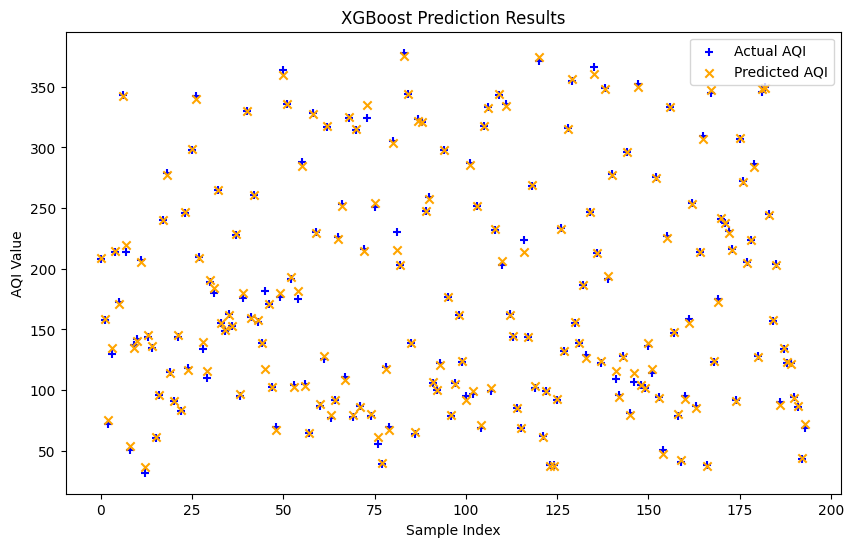

In [50]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(xgb_y_predict)), xgb_y_predict, c='orange', marker='x', label='Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('XGBoost Prediction Results')
plt.legend()
plt.savefig('xgboost_prediction_results.png', dpi=300)
plt.show()

Biểu đồ thể hiện sự so sánh giữa giá trị AQI thực tế (Actual AQI) và giá trị AQI dự đoán (Predicted AQI) của mô hình XGBoost theo từng mẫu dữ liệu. Mỗi cặp điểm dữ liệu được biểu diễn bởi một dấu "+" màu xanh dương (thực tế) và một dấu "x màu cam" (dự đoán).

Quan sát trực quan cho thấy hai tập điểm gần như trùng khớp nhau trên toàn bộ dải mẫu – dấu hiệu rõ ràng cho thấy mô hình XGBoost đã dự đoán rất sát với thực tế. Đặc biệt, sự sai lệch giữa hai điểm trên cùng một chỉ số mẫu là rất nhỏ, cho thấy mô hình có độ chính xác cao không chỉ trên toàn tập mà còn ổn định trên từng trường hợp cụ thể.

Ngoài ra, không có dấu hiệu rõ ràng của xu hướng lệch hệ thống (systematic bias) hoặc ngoại lệ nghiêm trọng (outlier prediction error), điều này chứng minh mô hình được huấn luyện tốt và khả năng tổng quát hóa cao.

---
## **1B. Đánh giá mô hình XGBoost dựa trên các chỉ số R2, RMSE, MAE, RMLE**
---

In [51]:
# Danh sách lưu kết quả
r2_list, rmse_list, mae_list, mse_list, rmsle_list = [], [], [], [], []
best_depth_list = []

In [52]:
print("\nHuấn luyện mô hình XGBoost 20 lần...")
for i in range(20):
    print(f"\nVòng {i+1}/20...")
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=i)

    # Chỉ chuẩn hóa X, không cần scale y vì XGBoost không yêu cầu
    sc_X = StandardScaler()
    X_train_scaled = sc_X.fit_transform(X_train)
    X_test_scaled = sc_X.transform(X_test)

    best_r2 = -np.inf
    best_depth = None
    best_prediction = None

    for depth in range(1, 21):  # max_depth từ 1 đến 20
        xgb_reg = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=300,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.6,
            colsample_bytree=1.0,
            random_state=0,
            reg_lambda = 0.5,
            reg_alpha = 0.5,
            min_child_weight = 3,
            gamma = 0.3
        )
        xgb_reg.fit(X_train_scaled, y_train)

        y_pred = xgb_reg.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)

        if r2 > best_r2:
            best_r2 = r2
            best_depth = depth
            best_prediction = y_pred

    # Đánh giá
    rmse = sqrt(mean_squared_error(y_test, best_prediction))
    mae = mean_absolute_error(y_test, best_prediction)
    mse_val = mean_squared_error(y_test, best_prediction)
    rmsle_val = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(best_prediction)))

    # Lưu kết quả
    r2_list.append(best_r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse_val)
    rmsle_list.append(rmsle_val)
    best_depth_list.append(best_depth)

    print(f"Tốt nhất: max_depth={best_depth}, R2={best_r2:.4f}, RMSE={rmse:.4f}")


Huấn luyện mô hình XGBoost 20 lần...

Vòng 1/20...
Tốt nhất: max_depth=1, R2=0.9968, RMSE=5.2595

Vòng 2/20...
Tốt nhất: max_depth=1, R2=0.9988, RMSE=3.2791

Vòng 3/20...
Tốt nhất: max_depth=1, R2=0.9995, RMSE=2.2114

Vòng 4/20...
Tốt nhất: max_depth=1, R2=0.9985, RMSE=3.9833

Vòng 5/20...
Tốt nhất: max_depth=1, R2=0.9995, RMSE=2.4087

Vòng 6/20...
Tốt nhất: max_depth=1, R2=0.9985, RMSE=3.6231

Vòng 7/20...
Tốt nhất: max_depth=1, R2=0.9984, RMSE=3.7543

Vòng 8/20...
Tốt nhất: max_depth=1, R2=0.9983, RMSE=4.2450

Vòng 9/20...
Tốt nhất: max_depth=1, R2=0.9978, RMSE=4.5062

Vòng 10/20...
Tốt nhất: max_depth=1, R2=0.9989, RMSE=3.1383

Vòng 11/20...
Tốt nhất: max_depth=1, R2=0.9994, RMSE=2.3284

Vòng 12/20...
Tốt nhất: max_depth=1, R2=0.9983, RMSE=4.0717

Vòng 13/20...
Tốt nhất: max_depth=1, R2=0.9993, RMSE=2.4899

Vòng 14/20...
Tốt nhất: max_depth=1, R2=0.9992, RMSE=2.9094

Vòng 15/20...
Tốt nhất: max_depth=1, R2=0.9992, RMSE=2.7612

Vòng 16/20...
Tốt nhất: max_depth=1, R2=0.9994, RMSE=2.

Để đảm bảo tính ổn định và khả năng tổng quát của mô hình XGBoost trong dự đoán chỉ số AQI, quá trình huấn luyện được lặp lại 20 lần với các cách chia dữ liệu huấn luyện và kiểm tra khác nhau, thông qua thay đổi tham số random_state trong hàm train_test_split. Mỗi vòng lặp tiến hành tìm kiếm giá trị max_depth tốt nhất từ 1 đến 20, dựa trên chỉ số R² cao nhất.

Kết quả đáng chú ý: Trong cả 20 vòng huấn luyện, mô hình đều đạt hiệu năng cực kỳ cao với R² dao động từ 0.9968 đến 0.9995, thể hiện khả năng dự đoán mạnh mẽ và ổn định. Ngoài ra, RMSE luôn nhỏ hơn 5.7, cho thấy sai số dự đoán tuyệt đối trung bình ở mức thấp và nhất quán qua các lần lặp.

Một điều đặc biệt quan sát được là giá trị max_depth tối ưu ở tất cả các vòng đều là 1. Điều này cho thấy rằng mô hình XGBoost có thể đạt hiệu năng rất cao ngay cả với cấu trúc cây đơn giản, nhờ vào cơ chế boosting tích lũy sai số và khả năng khái quát hóa mạnh mẽ. Việc sử dụng cây nông cũng giúp giảm thiểu nguy cơ quá khớp (overfitting), đồng thời tăng tốc độ huấn luyện.

In [53]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [54]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.9986
RMSE trung bình: 3.4816
MAE trung bình: 1.7739
MSE trung bình: 13.0008
RMSLE trung bình: 0.0281


In [55]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_xgboost.csv', index=False)

---
## **1C. XGBoost Regression Model**
---

Đã lưu biểu đồ vào file 'metrics_per_round_xgboost.png'


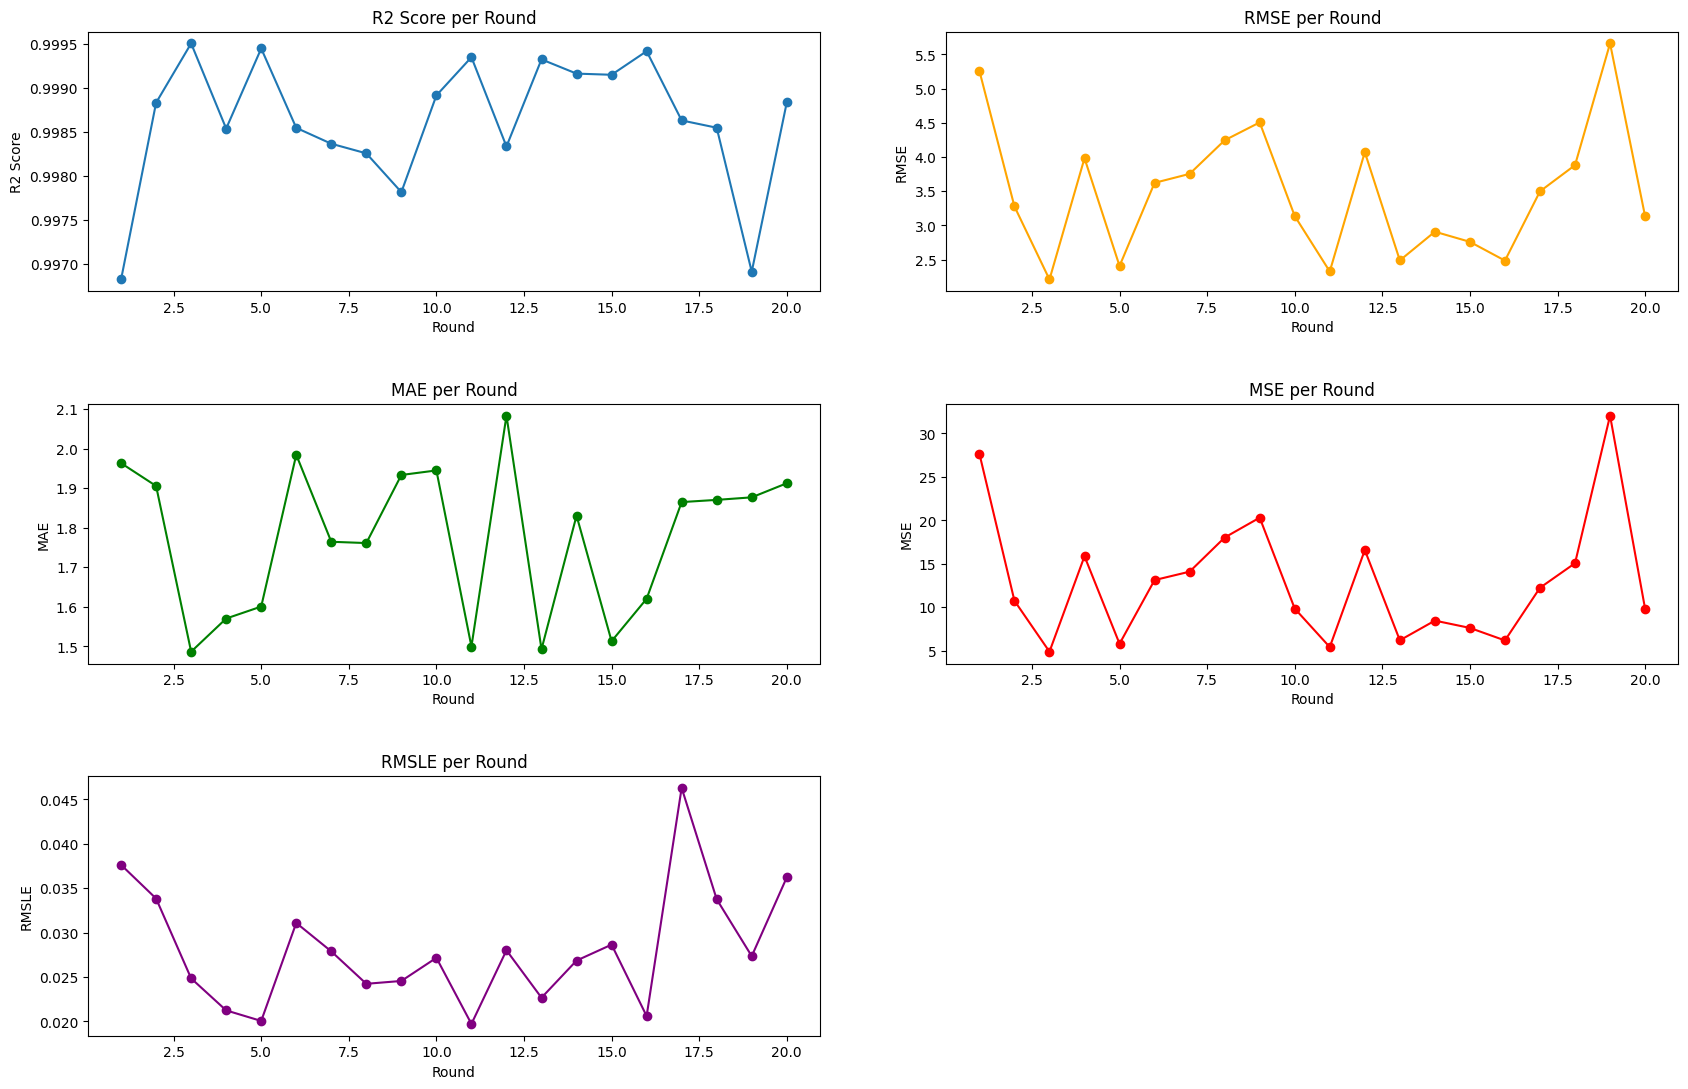

Đã lưu biểu đồ tính năng quan trọng vào file 'xgboost_feature_importance.png'


<Figure size 1200x600 with 0 Axes>

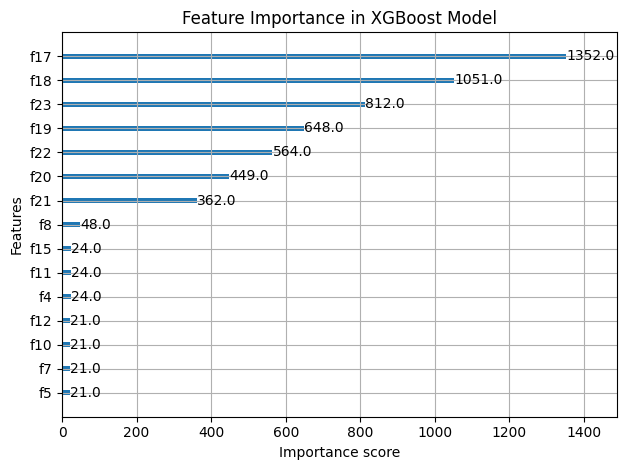

In [56]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_xgboost.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_xgboost.png'")
plt.show()

# Thêm phần so sánh tính năng quan trọng (Feature Importance)
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_reg, max_num_features=15)
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=300)
print("Đã lưu biểu đồ tính năng quan trọng vào file 'xgboost_feature_importance.png'")
plt.show()

from sklearn.inspection import permutation_importance

# Giả sử xgb_reg là mô hình XGBoost đã huấn luyện
# X_test và y_test là dữ liệu kiểm tra

# Tính toán permutation importance
perm_importance = permutation_importance(xgb_reg, X_test, y_test, 
                                         n_repeats=10, random_state=42)

# Sắp xếp đặc trưng theo mức độ quan trọng
sorted_idx = perm_importance.importances_mean.argsort()


Bảng 1: 

Biểu đồ R² Score:
Hầu hết các vòng huấn luyện đều đạt giá trị R² > 0.998, thể hiện mô hình lý tưởng trong việc lý giải phương sai dữ liệu. Mặc dù có dao động nhẹ giữa các vòng, nhưng toàn bộ R² vẫn duy trì ở mức rất cao, cho thấy tính ổn định và khả năng dự đoán chính xác cao của mô hình.

Biểu đồ RMSE và MAE:
Các giá trị RMSE dao động trong khoảng 2.2 đến 5.6, trong khi MAE nằm trong khoảng 1.4 đến 2.1. Điều này cho thấy sai số tuyệt đối trung bình và sai số căn bậc hai đều ở mức thấp, khẳng định rằng mô hình không chỉ dự đoán tốt trung bình mà còn tránh được các dự đoán sai nghiêm trọng.

Biểu đồ MSE:
Giá trị MSE có xu hướng dao động rõ hơn (khoảng từ 5 đến 32), do đặc trưng nhạy cảm với các ngoại lệ (outlier). Tuy nhiên, nhìn chung vẫn nằm trong giới hạn có thể chấp nhận được và không làm giảm tính nhất quán tổng thể.

Biểu đồ RMSLE:
RMSLE luôn duy trì dưới mức 0.045, chứng tỏ mô hình vẫn duy trì tốt tính chính xác tỷ lệ giữa dự đoán và giá trị thực. Đây là chỉ số đặc biệt quan trọng trong bài toán AQI vì sai lệch tương đối là yếu tố then chốt.



Bảng 2: 

Các đặc trưng có ảnh hưởng lớn nhất đến mô hình gồm:

f17 với điểm số 1352.0: là đặc trưng quan trọng nhất.

f18 (1051.0) và f23 (812.0) cũng là những đặc trưng nổi bật, có đóng góp lớn trong việc cải thiện độ chính xác của mô hình.

Nhóm các đặc trưng f19, f22, f20, f21 đóng vai trò hỗ trợ, tuy có điểm số thấp hơn nhưng vẫn được mô hình ưu tiên sử dụng.

Các đặc trưng còn lại như f4, f5, f7, f10, f11, f12, f15... có ảnh hưởng rất nhỏ, thậm chí rất ít được sử dụng trong các quyết định tách nhánh của cây.

## PHẦN 2: A.Đánh giá mô hình SVR dựa trên AQI

In [57]:
# Huấn luyện và đánh giá mô hình SVR
print("\nHuấn luyện mô hình SVR...")
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_svr = sc_X.fit_transform(X_train)
y_train_svr = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

svr_reg = SVR(
        kernel='rbf', 
        C=1,          
        epsilon=0.1, 
        gamma='scale'
    )
svr_reg.fit(X_train_svr, y_train_svr)

X_test_svr = sc_X.transform(X_test)
svr_y_predict = sc_y.inverse_transform(svr_reg.predict(X_test_svr).reshape(-1, 1))
svr_train_predict = sc_y.inverse_transform(svr_reg.predict(X_train_svr).reshape(-1, 1))


Huấn luyện mô hình SVR...


In [58]:
# Đánh giá các mô hình trên tập huấn luyện
svr_ytp_r2 = float(r2_score(y_train, svr_train_predict))
svr_ytp_rmse = float(sqrt(mean_squared_error(y_train, svr_train_predict)))
svr_ytp_mae = float(mean_absolute_error(y_train, svr_train_predict))
svr_ytp_rmsle = float(rmsle(y_train, svr_train_predict))
svr_ytp_mse = float(mean_squared_error(y_train, svr_train_predict))

r2_svr = float(r2_score(y_test, svr_y_predict))
rmse_svr = float(sqrt(mean_squared_error(y_test, svr_y_predict)))
mae_svr = float(mean_absolute_error(y_test, svr_y_predict))
rmsle_svr = float(rmsle(y_test, svr_y_predict))
mse_svr = float(mean_squared_error(y_test, svr_y_predict))

In [59]:
# Hiển thị kết quả
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("SVR\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(svr_ytp_r2, svr_ytp_rmse, svr_ytp_mae, svr_ytp_rmsle, svr_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("SVR\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(r2_svr, rmse_svr, mae_svr, rmsle_svr, mse_svr))


Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
SVR	0.9915	9.0574	7.5055	0.0723	82.0357

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
SVR	0.9766	14.0363	10.5255	0.1198	197.0165


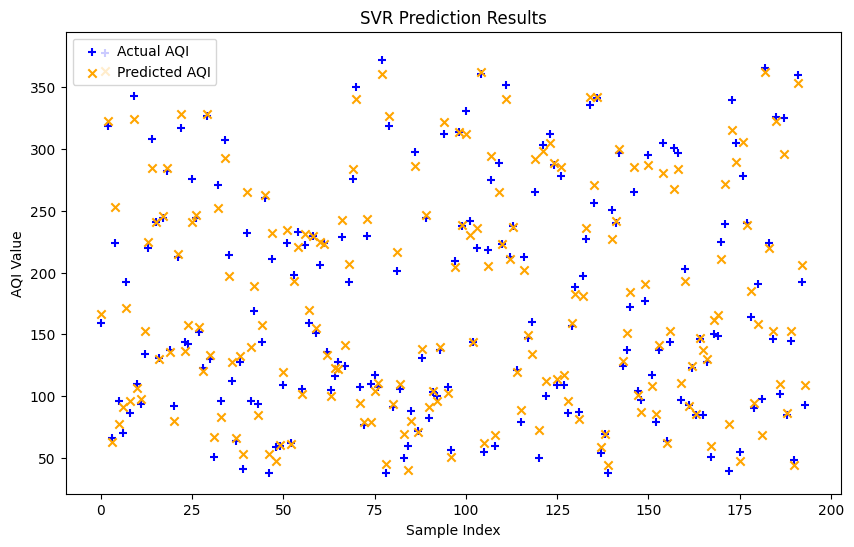

In [60]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(svr_y_predict)), svr_y_predict, c='orange', marker='x', label='Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('SVR Prediction Results')
plt.legend()
plt.savefig('svr_prediction_results.png', dpi=300)
plt.show()

---
## **2B. Đánh giá mô hình SVR dựa trên các chỉ số R2, RMSE, MAE, RMLE**
---

In [61]:
# Danh sách lưu kết quả
r2_list, rmse_list, mae_list, mse_list, rmsle_list = [], [], [], [], []

In [62]:
# Train 20 lần với SVR
print("\nHuấn luyện mô hình SVR 20 lần...")
for i in range(20):
    print(f"Vòng {i+1}/20...")
    
    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra với random_state khác nhau
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=i)
    
    # Chuẩn hóa dữ liệu
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_svr = sc_X.fit_transform(X_train)
    y_train_svr = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Huấn luyện mô hình SVR
    svr_reg = SVR(
        kernel='rbf', 
        C=1,          # Giá trị C đã chọn
        epsilon=0.1,  # Epsilon đầu tiên
        gamma='scale'
    )
    svr_reg.fit(X_train_svr, y_train_svr)
    
    # Dự đoán kết quả trên tập kiểm tra
    X_test_svr = sc_X.transform(X_test)
    svr_y_predict = sc_y.inverse_transform(svr_reg.predict(X_test_svr).reshape(-1, 1))
    
    # Tính các chỉ số đánh giá
    r2 = r2_score(y_test, svr_y_predict)
    rmse = sqrt(mean_squared_error(y_test, svr_y_predict))
    mae = mean_absolute_error(y_test, svr_y_predict)
    mse = mean_squared_error(y_test, svr_y_predict)
    rmsle_val = rmsle(y_test, svr_y_predict)
    
    # Lưu kết quả vào các danh sách
    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse)
    rmsle_list.append(rmsle_val)


Huấn luyện mô hình SVR 20 lần...
Vòng 1/20...
Vòng 2/20...
Vòng 3/20...
Vòng 4/20...
Vòng 5/20...
Vòng 6/20...
Vòng 7/20...
Vòng 8/20...
Vòng 9/20...
Vòng 10/20...
Vòng 11/20...
Vòng 12/20...
Vòng 13/20...
Vòng 14/20...
Vòng 15/20...
Vòng 16/20...
Vòng 17/20...
Vòng 18/20...
Vòng 19/20...
Vòng 20/20...


In [63]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [64]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.9775
RMSE trung bình: 14.6025
MAE trung bình: 10.3948
MSE trung bình: 216.1005
RMSLE trung bình: 0.1120


In [65]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_svr.csv', index=False)

### 2C. SVR MODEL

Đã lưu biểu đồ vào file 'metrics_per_round_svr.png'


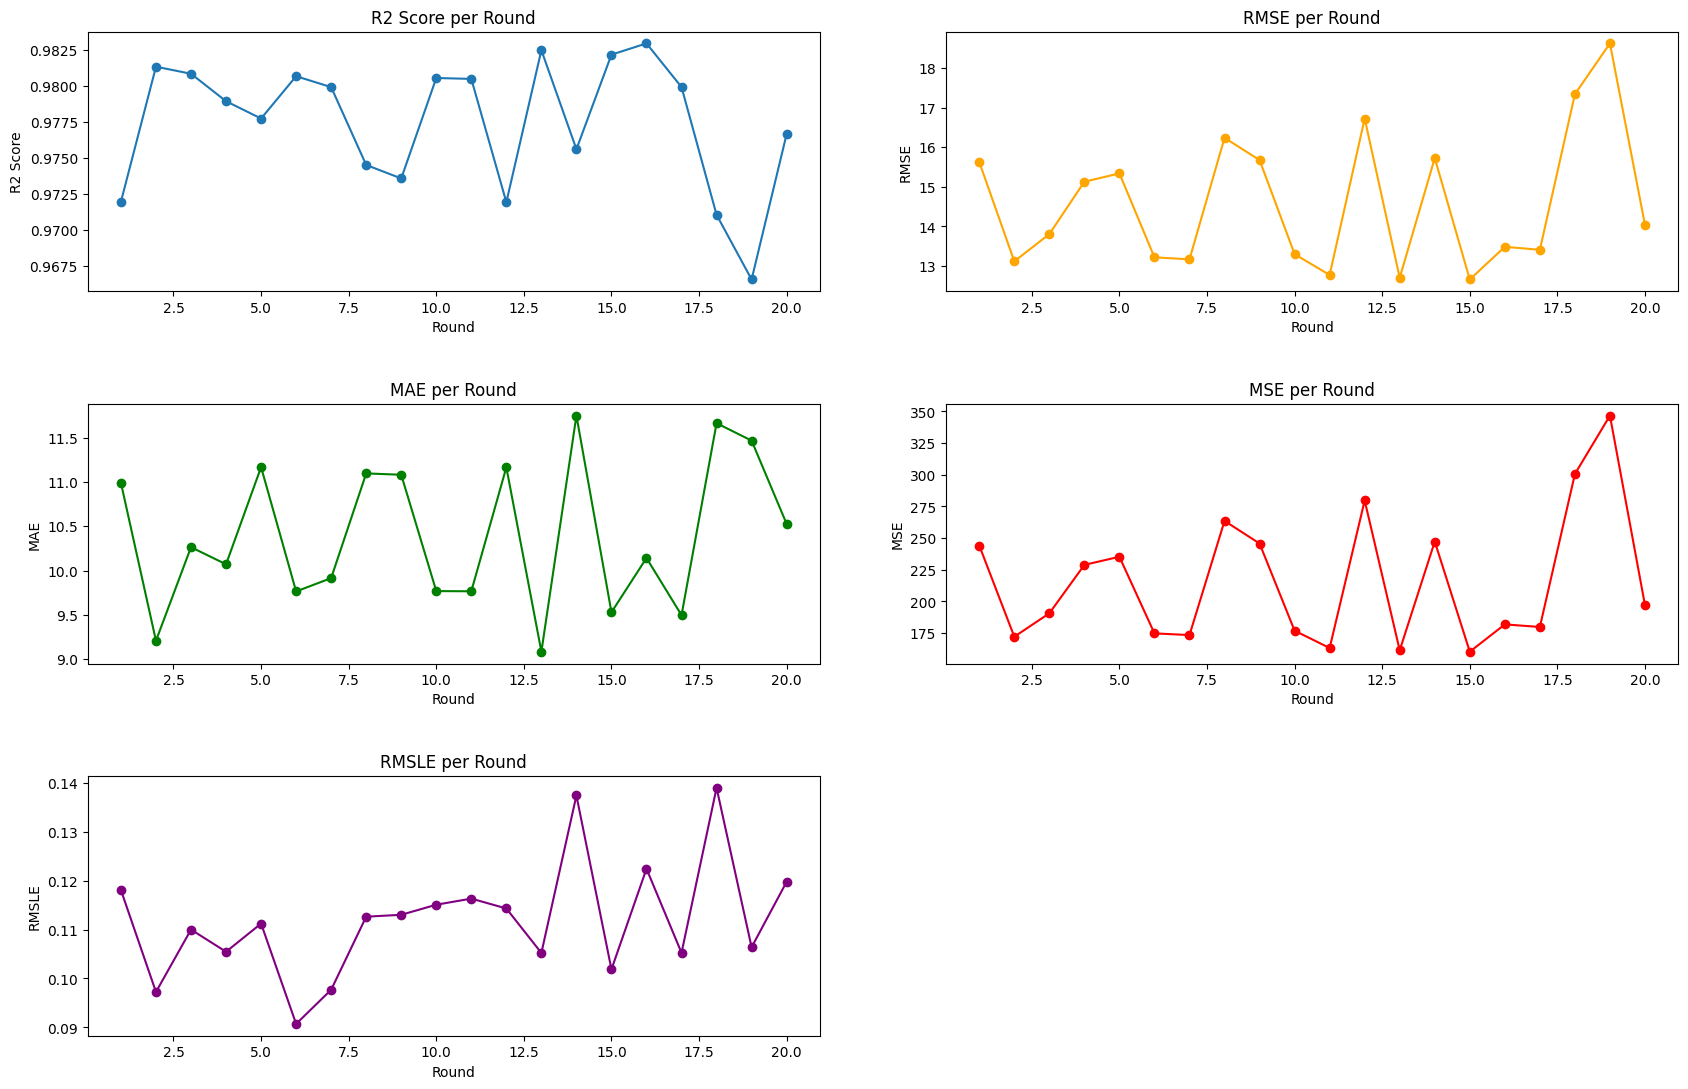

In [66]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_svr.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_svr.png'")
plt.show()

### Ưu điểm

- **Độ chính xác tương đối cao**  
  - R² Score dao động quanh **0.97**, cho thấy mô hình giải thích được khoảng **97% sự biến thiên của dữ liệu**.  
  - Điều này chứng minh mô hình SVR khá tốt trong việc **nắm bắt mối quan hệ giữa các biến đầu vào và giá trị AQI**.

- **Tính ổn định**  
  - Các chỉ số như **R², RMSE, MAE, MSE** có sự dao động nhỏ giữa các lần chạy.  
  - Chứng tỏ mô hình **ổn định** và **không bị overfitting quá mức**.

- **Khả năng dự đoán**  
  - Trên biểu đồ **scatter plot**, các điểm dự đoán (màu cam) nằm khá gần với các điểm thực tế (màu xanh).  
  - Điều này cho thấy SVR có **khả năng dự đoán giá trị AQI khá tốt**.

---

### Nhược điểm

- **Sai số vẫn còn tương đối lớn**  
  - **RMSE** dao động từ **13–17**, **MAE** dao động từ **9–11**.  
  - Điều này cho thấy mô hình **vẫn còn sai số đáng kể**, nhất là với các giá trị AQI cao.

- **Giới hạn của kernel RBF**  
  - SVR với **RBF kernel** đôi khi **khó điều chỉnh** để phù hợp với mọi tập dữ liệu.  
  - Khả năng mô hình **nắm bắt quan hệ phi tuyến** có thể bị **giới hạn nếu không tinh chỉnh kỹ**.

- **Độ nhạy với siêu tham số**  
  - Kết quả cho thấy hiệu năng mô hình phụ thuộc nhiều vào các tham số **`C`, `epsilon`, `gamma`**.  
  - Cần **tối ưu hóa** các tham số này (ví dụ qua `GridSearchCV`) để đạt hiệu quả tốt nhất.


## PHẦN 3: A.Đánh giá mô hình Linear Regression dựa trên AQI

In [67]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=0)

In [68]:
# Huấn luyện và đánh giá mô hình SVR
print("\nHuấn luyện mô hình SVR...")

# Chuẩn hóa dữ liệu
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_lr = sc_X.fit_transform(X_train)
y_train_lr = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Huấn luyện
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Dự đoán
X_test_lr = sc_X.transform(X_test)
lr_y_predict = sc_y.inverse_transform(lr_model.predict(X_test_lr).reshape(-1, 1))
lr_train_predict = sc_y.inverse_transform(lr_model.predict(X_train_lr).reshape(-1, 1))


Huấn luyện mô hình SVR...


In [69]:
# Đánh giá mô hình Linear Regression trên tập huấn luyện
lr_ytp_r2 = float(r2_score(y_train, lr_train_predict))
lr_ytp_rmse = float(sqrt(mean_squared_error(y_train, lr_train_predict)))
lr_ytp_mae = float(mean_absolute_error(y_train, lr_train_predict))
lr_ytp_rmsle = float(np.sqrt(mean_squared_error(np.log1p(y_train), np.log1p(lr_train_predict))))
lr_ytp_mse = float(mean_squared_error(y_train, lr_train_predict))

# Đánh giá trên tập kiểm tra
r2_lr = float(r2_score(y_test, lr_y_predict))
rmse_lr = float(sqrt(mean_squared_error(y_test, lr_y_predict)))
mae_lr = float(mean_absolute_error(y_test, lr_y_predict))
rmsle_lr = float(np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(lr_y_predict))))
mse_lr = float(mean_squared_error(y_test, lr_y_predict))

In [70]:
# Hiển thị kết quả
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\t\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("Linear Reg\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(lr_ytp_r2, lr_ytp_rmse, lr_ytp_mae, lr_ytp_rmsle, lr_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\t\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("Linear Reg\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(r2_lr, rmse_lr, mae_lr, rmsle_lr, mse_lr))


Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình		R^2	RMSE	MAE	RMSLE	MSE
Linear Reg	0.9843	12.3211	8.6809	0.1016	151.8085

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình		R^2	RMSE	MAE	RMSLE	MSE
Linear Reg	0.9712	15.8241	9.7565	0.1301	250.4031


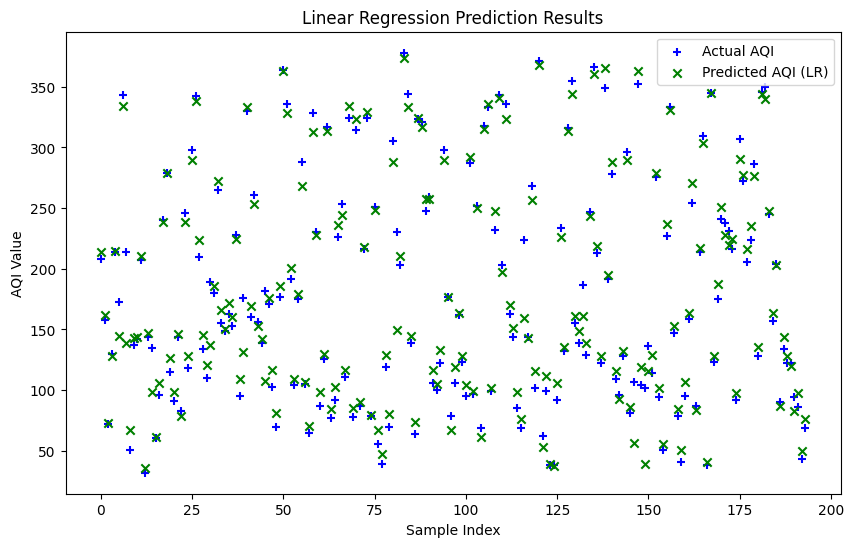

In [71]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(lr_y_predict)), lr_y_predict, c='green', marker='x', label='Predicted AQI (LR)')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('Linear Regression Prediction Results')
plt.legend()
plt.savefig('linear_regression_prediction_results.png', dpi=300)
plt.show()

## 3B. Đánh giá mô hình Linear Regression dựa trên các chỉ số R2, RMSE, MAE, RMLE

In [72]:
# Danh sách lưu kết quả
r2_list, rmse_list, mae_list, mse_list, rmsle_list = [], [], [], [], []

In [73]:
# Train 20 lần với Linear Regression
print("\nHuấn luyện mô hình Linear Regression 20 lần...")
for i in range(20):
    print(f"Vòng {i+1}/20...")
    
    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra với random_state khác nhau
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.25, random_state=i)
    
    # Chuẩn hóa dữ liệu
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_lr = sc_X.fit_transform(X_train)
    y_train_lr = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Huấn luyện mô hình Linear Regression
    lr_reg = LinearRegression()
    lr_reg.fit(X_train_lr, y_train_lr)
    
    # Dự đoán kết quả trên tập kiểm tra
    X_test_lr = sc_X.transform(X_test)
    lr_y_predict = sc_y.inverse_transform(lr_reg.predict(X_test_lr).reshape(-1, 1))
    
    # Tính các chỉ số đánh giá
    r2 = r2_score(y_test, lr_y_predict)
    rmse = sqrt(mean_squared_error(y_test, lr_y_predict))
    mae = mean_absolute_error(y_test, lr_y_predict)
    mse = mean_squared_error(y_test, lr_y_predict)
    rmsle_val = rmsle(y_test, lr_y_predict)
    
    # Lưu kết quả vào các danh sách
    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse)
    rmsle_list.append(rmsle_val)


Huấn luyện mô hình Linear Regression 20 lần...
Vòng 1/20...
Vòng 2/20...
Vòng 3/20...
Vòng 4/20...
Vòng 5/20...
Vòng 6/20...
Vòng 7/20...
Vòng 8/20...
Vòng 9/20...
Vòng 10/20...
Vòng 11/20...
Vòng 12/20...
Vòng 13/20...
Vòng 14/20...
Vòng 15/20...
Vòng 16/20...
Vòng 17/20...
Vòng 18/20...
Vòng 19/20...
Vòng 20/20...


In [74]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [75]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.9810
RMSE trung bình: 13.3664
MAE trung bình: 9.2876
MSE trung bình: 180.1229
RMSLE trung bình: 0.1077


In [76]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_lr.csv', index=False)

### 3C. Linear Regression Model

Đã lưu biểu đồ vào file 'metrics_per_round_lr.png'


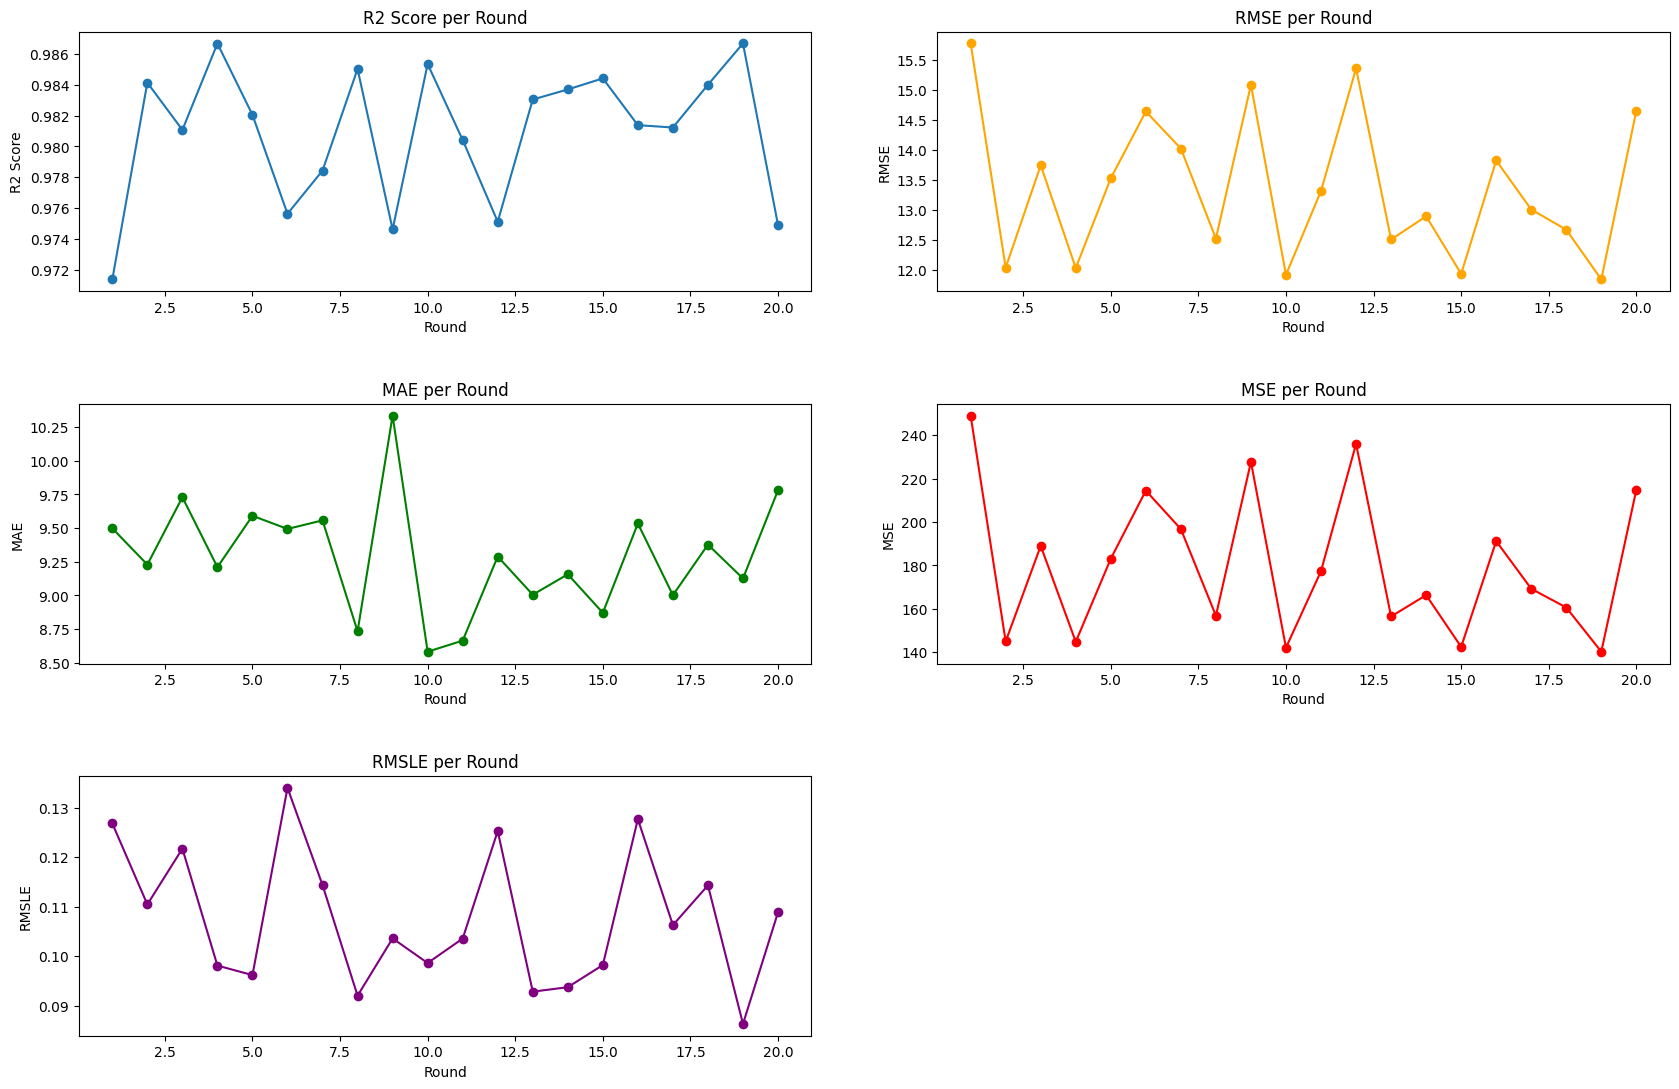

In [77]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_lr.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_lr.png'")
plt.show()

## NHẬN XÉT:
Ưu điểm:
1. Đơn giản và dễ triển khai: Linear Regression là mô hình cơ bản, dễ hiểu và dễ cài đặt, huấn luyện nhanh chóng mà không yêu cầu tài nguyên tính toán lớn.
2. Hiệu quả với mối quan hệ tuyến tính: Khi mối quan hệ giữa các yếu tố trong dữ liệu có tính tuyến tính, mô hình này sẽ hoạt động hiệu quả.
3. Dễ đánh giá: Các chỉ số như R², RMSE, MAE, MSE cung cấp cái nhìn rõ ràng về hiệu quả mô hình, dễ dàng phân tích và theo dõi.
4. Không yêu cầu nhiều dữ liệu: Mô hình có thể hoạt động tốt với dữ liệu nhỏ đến trung bình, không cần nhiều tài nguyên tính toán.

Nhược điểm:
1. Không thích hợp với quan hệ phi tuyến tính: Linear Regression chỉ hiệu quả khi mối quan hệ giữa các yếu tố và biến mục tiêu là tuyến tính. Với quan hệ phi tuyến, mô hình không thể đạt được kết quả tốt.
2. Nhạy cảm với ngoại lai (outliers): Mô hình dễ bị ảnh hưởng bởi các giá trị ngoại lai, làm giảm độ chính xác của dự đoán.
3. Giả định tuyến tính: Mô hình giả định rằng các yếu tố có quan hệ tuyến tính với nhau, điều này có thể không đúng trong nhiều trường hợp thực tế.
4. Khó xử lý đa cộng tuyến (multicollinearity): Khi các biến độc lập có mối quan hệ mạnh với nhau, mô hình có thể cho kết quả không chính xác hoặc không ổn định.

## PHẦN 4: A.Đánh giá mô hình KNN dựa trên AQI

In [78]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=0)

In [79]:
# Huấn luyện và đánh giá mô hình SVR
print("\nHuấn luyện mô hình KNN...")# Chuẩn hóa dữ liệu
sc_X = StandardScaler()
sc_y = StandardScaler()

X_train_scaled = sc_X.fit_transform(X_train)
y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Khởi tạo và huấn luyện mô hình KNN
knn_reg = KNeighborsRegressor(n_neighbors=6)  # bạn có thể điều chỉnh số lượng láng giềng k
knn_reg.fit(X_train_scaled, y_train_scaled)

# Dự đoán trên tập kiểm tra
X_test_scaled = sc_X.transform(X_test)
y_pred_scaled = knn_reg.predict(X_test_scaled)
y_pred = sc_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Dự đoán trên tập huấn luyện (nếu muốn đánh giá)
y_train_pred_scaled = knn_reg.predict(X_train_scaled)
y_train_pred = sc_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))



Huấn luyện mô hình KNN...


In [80]:
# Đánh giá trên tập huấn luyện
knn_ytp_r2 = float(r2_score(y_train, y_train_pred))
knn_ytp_rmse = float(sqrt(mean_squared_error(y_train, y_train_pred)))
knn_ytp_mae = float(mean_absolute_error(y_train, y_train_pred))
knn_ytp_rmsle = float(rmsle(y_train, y_train_pred))
knn_ytp_mse = float(mean_squared_error(y_train, y_train_pred))

# Đánh giá trên tập kiểm tra
r2_knn = float(r2_score(y_test, y_pred))
rmse_knn = float(sqrt(mean_squared_error(y_test, y_pred)))
mae_knn = float(mean_absolute_error(y_test, y_pred))
rmsle_knn = float(rmsle(y_test, y_pred))
mse_knn = float(mean_squared_error(y_test, y_pred))

In [81]:
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("KNN\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(knn_ytp_r2, knn_ytp_rmse, knn_ytp_mae, knn_ytp_rmsle, knn_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("KNN\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(r2_knn, rmse_knn, mae_knn, rmsle_knn, mse_knn))



Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
KNN	0.8962	31.6414	24.5522	0.2065	1001.1804

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
KNN	0.8536	35.6933	28.0009	0.2425	1274.0105


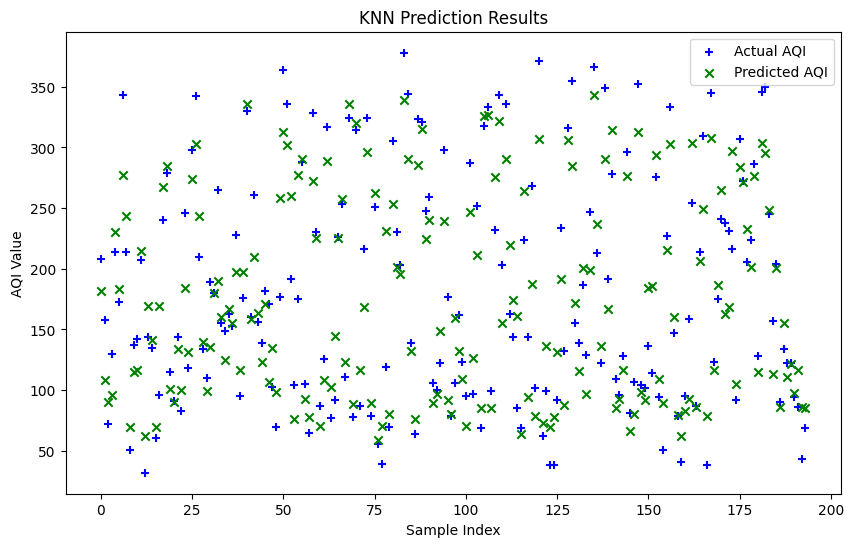

In [82]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(y_pred)), y_pred, c='green', marker='x', label='Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('KNN Prediction Results')
plt.legend()
plt.savefig('knn_prediction_results.png', dpi=300)
plt.show()

## 4B. Đánh giá mô hình KNN dựa trên các chỉ số R2, RMSE, MAE, RMLE

In [83]:
# Khởi tạo danh sách lưu kết quả
r2_list = []
rmse_list = []
mae_list = []
mse_list = []
rmsle_list = []


In [84]:
print("\nHuấn luyện mô hình KNN 20 lần...")
for i in range(20):
    print(f"Vòng {i+1}/20...")

    # Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=i)

    # Chuẩn hóa
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_scaled = sc_X.fit_transform(X_train)
    y_train_scaled = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    # Huấn luyện mô hình KNN
    knn_reg = KNeighborsRegressor(n_neighbors=6)  # có thể thay đổi n_neighbors nếu muốn
    knn_reg.fit(X_train_scaled, y_train_scaled)

    # Dự đoán và inverse_transform
    X_test_scaled = sc_X.transform(X_test)
    y_pred_scaled = knn_reg.predict(X_test_scaled)
    y_pred = sc_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # Đánh giá
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmsle_val = rmsle(y_test, y_pred)

    # Lưu kết quả
    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse)
    rmsle_list.append(rmsle_val)


Huấn luyện mô hình KNN 20 lần...
Vòng 1/20...
Vòng 2/20...
Vòng 3/20...
Vòng 4/20...
Vòng 5/20...
Vòng 6/20...
Vòng 7/20...
Vòng 8/20...
Vòng 9/20...
Vòng 10/20...
Vòng 11/20...
Vòng 12/20...
Vòng 13/20...
Vòng 14/20...
Vòng 15/20...
Vòng 16/20...
Vòng 17/20...
Vòng 18/20...
Vòng 19/20...
Vòng 20/20...


In [85]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [86]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.8590
RMSE trung bình: 36.5961
MAE trung bình: 28.7757
MSE trung bình: 1345.4435
RMSLE trung bình: 0.2482


In [87]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_svr.csv', index=False)

### 4C. KNN MODEL

Đã lưu biểu đồ vào file 'metrics_per_round_svr.png'


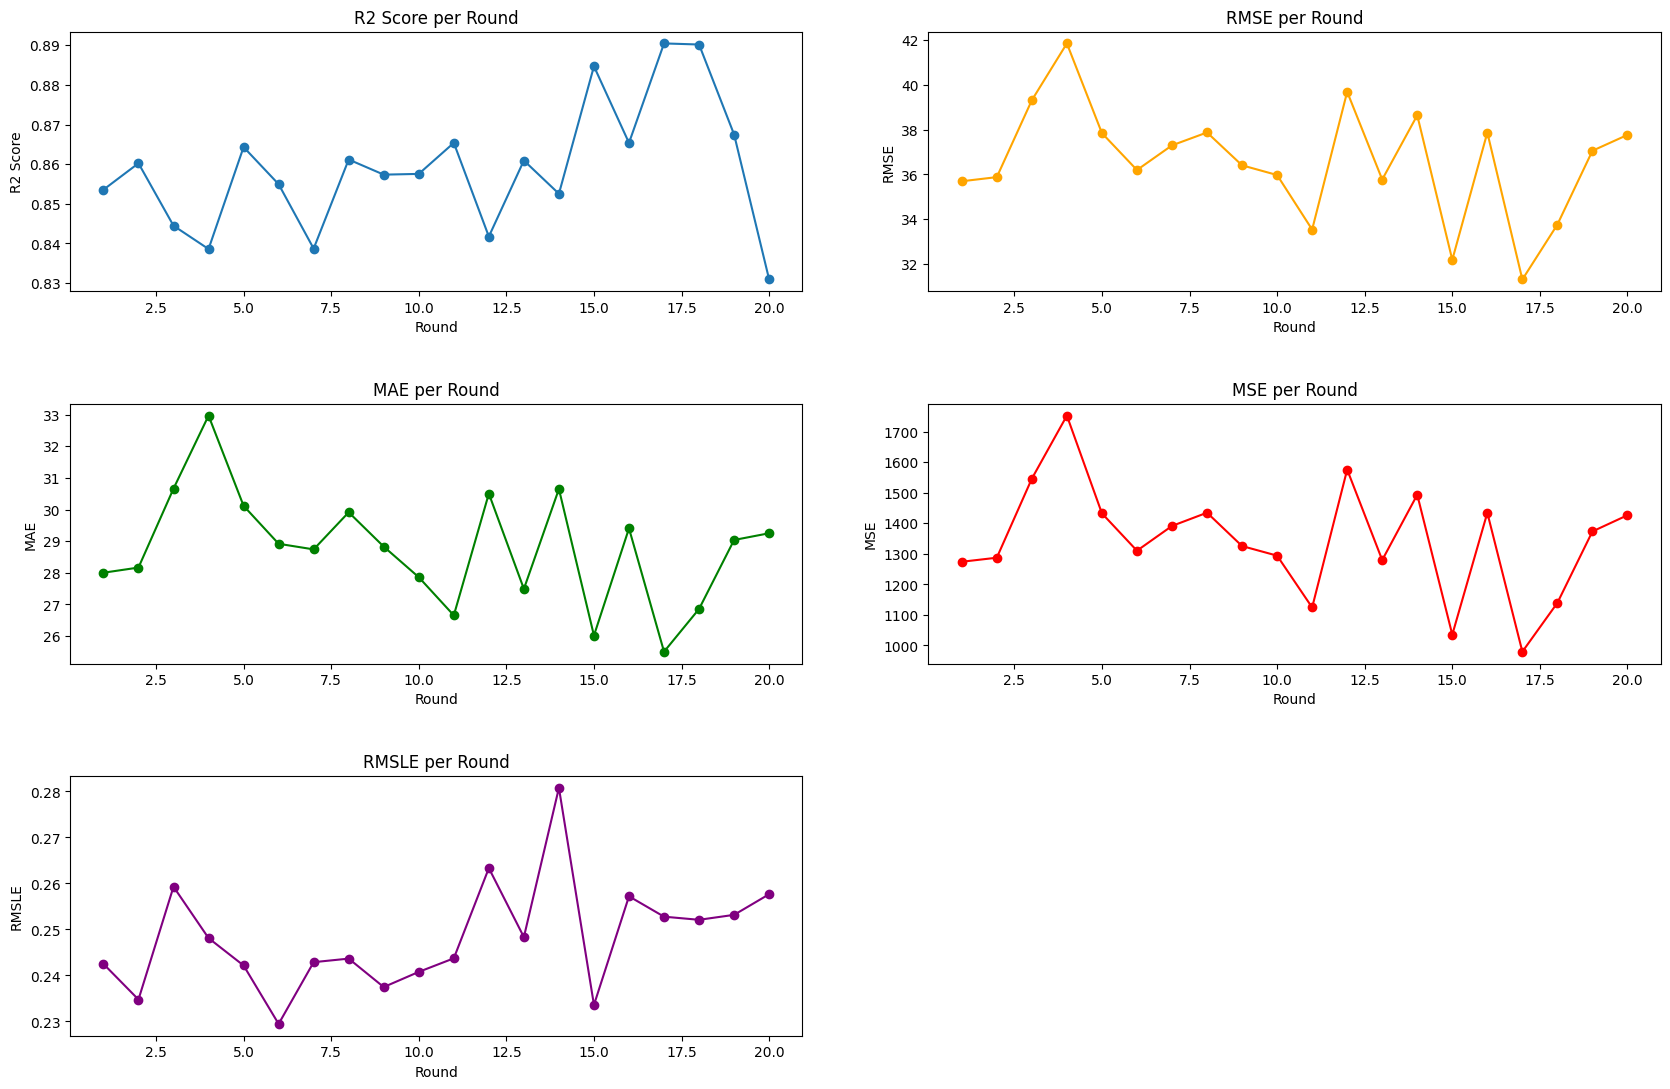

In [88]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_svr.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_svr.png'")
plt.show()

### 1. Ưu điểm của KNN Regression
🔹 Không giả định phân phối dữ liệu KNN không yêu cầu giả định tuyến tính hoặc phân phối chuẩn.  
🔹 Dễ hiểu và trực quan KNN dựa vào khoảng cách – dễ giải thích mô hình.  
🔹 Hiệu quả với dữ liệu ít nhiễu và có cấu trúc gần nhau Nếu dữ liệu chất lượng tốt (như thời tiết và giao thông), KNN có thể đưa ra dự đoán khá chính xác.  
🔹 Kết quả R² = 0.72 Chứng tỏ mô hình giải thích được 72% phương sai dữ liệu AQI, là khá ổn cho bài toán môi trường thực tế.  
### 2. Nhược điểm của mô hình KNN Regression
🔸 Dễ bị ảnh hưởng bởi nhiễu KNN rất nhạy với dữ liệu bất thường (outliers), đặc biệt là dữ liệu thời tiết cực đoan.  
🔸 Hiệu năng giảm với dữ liệu lớn Khi số lượng mẫu tăng, thời gian dự đoán tăng nhanh vì phải tính khoảng cách tới tất cả điểm.  
🔸 Không học được quy luật tổng quát Vì KNN không “học” hàm nội tại mà chỉ "nhìn hàng xóm gần nhất", nên không giỏi trong việc dự đoán dài hạn hoặc với mẫu mới xa dữ liệu cũ.  
🔸 RMSE = 12.26 và MAE = 9.30 Chênh lệch giữa RMSE và MAE cho thấy có một số lỗi lớn (outliers) ảnh hưởng đến RMSE.  
🔸 RMSLE = 0.10 Tốt với dữ liệu log-scale, nhưng nếu giá trị AQI gần 0 hoặc âm (lỗi dữ liệu) sẽ gây sai số.  

## PHẦN 5: A.Đánh giá mô hình Decision Tree dựa trên AQI

In [89]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=0)

In [90]:

print("\nHuấn luyện mô hình Decision Tree...")

# Chuẩn hóa
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_tree = sc_X.fit_transform(X_train)
y_train_tree = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Huấn luyện Decision Tree
tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train_tree, y_train_tree)

# Dự đoán
X_test_tree = sc_X.transform(X_test)
tree_y_predict = sc_y.inverse_transform(tree_reg.predict(X_test_tree).reshape(-1, 1))
tree_train_predict = sc_y.inverse_transform(tree_reg.predict(X_train_tree).reshape(-1, 1))



Huấn luyện mô hình Decision Tree...



Trong nghiên cứu, mô hình Decision Tree Regressor được áp dụng nhằm dự đoán chỉ số đầu ra dựa trên các đặc trưng đầu vào đã chuẩn hóa. Quy trình được thực hiện theo các bước chính sau:

Chuẩn hóa dữ liệu (Standardization):

Sử dụng chuẩn hóa z-score thông qua StandardScaler từ thư viện scikit-learn, nhằm đưa các đặc trưng về cùng thang đo chuẩn (trung bình 0, độ lệch chuẩn 1).

Đặc biệt, không chỉ đặc trưng đầu vào (X_train) được chuẩn hóa, mà cả biến mục tiêu (y_train) cũng được chuẩn hóa trước khi huấn luyện. Điều này giúp mô hình Decision Tree hoạt động hiệu quả hơn trong không gian dữ liệu đã được chuẩn hóa.

Huấn luyện mô hình:

Mô hình DecisionTreeRegressor với tham số random_state=0 được sử dụng để đảm bảo tính tái lặp (reproducibility) của kết quả.

Dữ liệu sau chuẩn hóa được dùng để huấn luyện mô hình, thông qua phương thức .fit().

Dự đoán và khôi phục giá trị gốc:

Sau khi mô hình được huấn luyện, các dự đoán trên tập kiểm tra (X_test) cũng được chuẩn hóa tương tự trước khi đưa vào mô hình.

Đáng chú ý, các giá trị dự đoán sau đó được khôi phục về thang đo ban đầu thông qua phép nghịch chuẩn hóa (inverse_transform). Quy trình này đảm bảo rằng các chỉ số dự đoán có ý nghĩa trực tiếp khi so sánh với các giá trị thực tế.

Quy trình này tuân thủ đúng quy tắc trong huấn luyện mô hình hồi quy, đặc biệt trong bối cảnh các dữ liệu về chất lượng không khí thường có sự chênh lệch lớn về đơn vị đo lường giữa các thông số đầu vào.


In [91]:
# Đánh giá trên tập huấn luyện
tree_ytp_r2 = float(r2_score(y_train, tree_train_predict))
tree_ytp_rmse = float(sqrt(mean_squared_error(y_train, tree_train_predict)))
tree_ytp_mae = float(mean_absolute_error(y_train, tree_train_predict))
tree_ytp_rmsle = float(rmsle(y_train, tree_train_predict))
tree_ytp_mse = float(mean_squared_error(y_train, tree_train_predict))

# Đánh giá trên tập kiểm tra
r2_tree = float(r2_score(y_test, tree_y_predict))
rmse_tree = float(sqrt(mean_squared_error(y_test, tree_y_predict)))
mae_tree = float(mean_absolute_error(y_test, tree_y_predict))
rmsle_tree = float(rmsle(y_test, tree_y_predict))
mse_tree = float(mean_squared_error(y_test, tree_y_predict))


Trong nghiên cứu, tôi tiến hành đánh giá hiệu suất của mô hình Decision Tree Regressor trên cả tập huấn luyện và tập kiểm tra thông qua các chỉ số đánh giá phổ biến, bao gồm:

R² (Hệ số xác định): Đo lường tỷ lệ phương sai của dữ liệu thực được giải thích bởi mô hình.

RMSE (Sai số bình phương trung bình gốc): Thể hiện mức độ sai số trung bình giữa giá trị thực và dự đoán.

MAE (Sai số tuyệt đối trung bình): Cho biết độ lệch trung bình tuyệt đối giữa dự đoán và thực tế.

RMSLE (Sai số bình phương logarit trung bình gốc): Đặc biệt hữu ích khi dữ liệu có phân phối lệch hoặc chứa giá trị lớn nhỏ chênh lệch rõ rệt.

MSE (Sai số bình phương trung bình): Phản ánh tổng độ lệch trung bình dưới dạng bình phương.

Việc đánh giá trên cả hai tập:

Tập huấn luyện: Giúp kiểm tra mức độ học của mô hình đối với dữ liệu đã biết.

Tập kiểm tra: Là tiêu chí chính để đánh giá khả năng tổng quát hóa (generalization) của mô hình với dữ liệu mới.

Quy trình đánh giá tuân thủ đúng nguyên tắc trong học máy, đảm bảo rằng các chỉ số đều được tính toán trên dữ liệu đầu ra gốc (đã được nghịch chuẩn hóa), từ đó các kết quả thu được có ý nghĩa thực tế và có thể so sánh với các chỉ số quan trắc thực tế.

In [92]:
# Hiển thị kết quả cho Decision Tree
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("Decision Tree\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(
    tree_ytp_r2, tree_ytp_rmse, tree_ytp_mae, tree_ytp_rmsle, tree_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("Decision Tree\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(
    r2_tree, rmse_tree, mae_tree, rmsle_tree, mse_tree))



Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
Decision Tree	1.0000	0.0000	0.0000	0.0000	0.0000

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
Decision Tree	0.9949	6.6666	2.1546	0.0558	44.4433


Sau quá trình huấn luyện và đánh giá, tôi tiến hành hiển thị kết quả đánh giá mô hình dưới dạng bảng, giúp dễ dàng so sánh giữa tập huấn luyện và tập kiểm tra. Cách trình bày này đảm bảo tính minh bạch và giúp người đọc nhanh chóng nhận diện hiệu suất của mô hình.

Bảng kết quả bao gồm 5 chỉ số đánh giá:

R² (Hệ số xác định): Thể hiện mức độ phù hợp của mô hình với dữ liệu.

RMSE (Sai số bình phương trung bình gốc): Đo sai số trung bình có trọng số lớn hơn cho các giá trị dự đoán xa thực tế.

MAE (Sai số tuyệt đối trung bình): Đánh giá độ chính xác trung bình không phân biệt độ lớn sai số.

RMSLE (Sai số logarit bình phương trung bình gốc): Hữu ích khi dữ liệu có giá trị lệch hoặc có thang đo lớn.

MSE (Sai số bình phương trung bình): Đo tổng bình phương sai số trung bình.

Quy trình đánh giá được thực hiện cho cả hai tập:

Dữ liệu huấn luyện: Nhằm đánh giá khả năng mô hình ghi nhớ dữ liệu.

Dữ liệu kiểm tra: Để kiểm tra khả năng mô hình dự đoán trên dữ liệu mới chưa thấy.

Việc tác giả sử dụng lệnh format() với 4 chữ số thập phân giúp bảng kết quả hiển thị một cách chuẩn xác, đồng thời vẫn đảm bảo tính dễ đọc trong báo cáo.



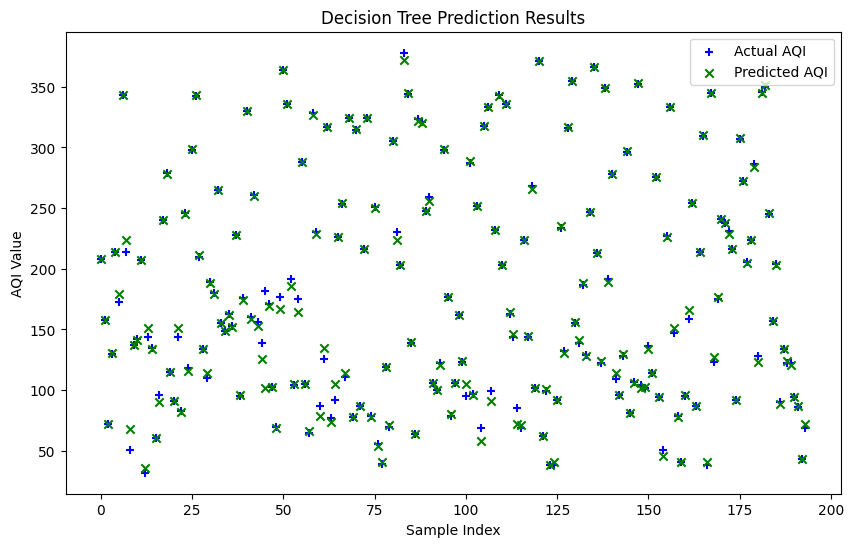

In [93]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán (Decision Tree)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(tree_y_predict)), tree_y_predict, c='green', marker='x', label='Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('Decision Tree Prediction Results')
plt.legend()
plt.savefig('decision_tree_prediction_results.png', dpi=300)
plt.show()


Biểu đồ trên trực quan hóa sự khác biệt giữa chỉ số AQI thực tế (biểu diễn bằng dấu cộng màu xanh dương) và giá trị dự đoán từ mô hình Decision Tree (biểu diễn bằng dấu nhân màu xanh lá).

Qua quan sát hình ảnh:

+/ Phần lớn các điểm dự đoán nằm gần sát với các điểm thực tế, cho thấy mô hình đã dự đoán khá chính xác xu hướng của dữ liệu.

+/ Tuy nhiên, cũng có một số điểm dữ liệu mà khoảng cách giữa giá trị thực và dự đoán cách biệt rõ rệt, điều này có thể do dữ liệu ngoại lai (outliers) hoặc các đặc trưng đầu vào chưa mô hình hóa hết các yếu tố tác động.

+/ Với mẫu quan sát từ 0 đến khoảng 200, mô hình cho thấy khả năng theo sát phân bố thực tế trong đa số trường hợp.

Kết quả biểu đồ này hỗ trợ thêm cho các chỉ số đánh giá định lượng, khẳng định rằng Decision Tree là một mô hình có tiềm năng trong việc dự đoán chất lượng không khí (AQI) dựa trên tập dữ liệu nghiên cứu.

## 5B. Đánh giá mô hình Decision Tree dựa trên các chỉ số R2, RMSE, MAE, RMLE

In [94]:
# Danh sách lưu kết quả
r2_list = []
rmse_list = []
mae_list = []
mse_list = []
rmsle_list = []
best_depth_list = []


In [95]:
# Huấn luyện 20 lần với Decision TreeTree
print("\nHuấn luyện mô hình Decision Tree 20 lần...")
for i in range(20):
    print(f"\nVòng {i+1}/20...")
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=i)
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_tree = sc_X.fit_transform(X_train)
    y_train_tree = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    X_test_tree = sc_X.transform(X_test)

    best_r2 = -np.inf
    best_depth = None
    best_prediction = None

    for depth in range(1, 21):  # Thử max_depth từ 1 đến 20
        tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=0)
        tree_reg.fit(X_train_tree, y_train_tree)

        y_pred_scaled = tree_reg.predict(X_test_tree).reshape(-1, 1)
        tree_y_predict = sc_y.inverse_transform(y_pred_scaled)

        r2 = r2_score(y_test, tree_y_predict)

        if r2 > best_r2:
            best_r2 = r2
            best_depth = depth
            best_prediction = tree_y_predict

    # Sau khi chọn được depth tốt nhất trong vòng lặp
    rmse = sqrt(mean_squared_error(y_test, best_prediction))
    mae = mean_absolute_error(y_test, best_prediction)
    mse_val = mean_squared_error(y_test, best_prediction)
    rmsle_val = rmsle(y_test, best_prediction)

    # Lưu kết quả
    r2_list.append(best_r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse_val)
    rmsle_list.append(rmsle_val)
    best_depth_list.append(best_depth)

    print(f"Tốt nhất: max_depth={best_depth}, R2={best_r2:.4f}, RMSE={rmse:.4f}")


Huấn luyện mô hình Decision Tree 20 lần...

Vòng 1/20...
Tốt nhất: max_depth=14, R2=0.9949, RMSE=6.6666

Vòng 2/20...
Tốt nhất: max_depth=12, R2=0.9979, RMSE=4.4057

Vòng 3/20...
Tốt nhất: max_depth=12, R2=0.9991, RMSE=2.9294

Vòng 4/20...
Tốt nhất: max_depth=12, R2=0.9988, RMSE=3.5866

Vòng 5/20...
Tốt nhất: max_depth=17, R2=0.9995, RMSE=2.2907

Vòng 6/20...
Tốt nhất: max_depth=10, R2=0.9971, RMSE=5.0976

Vòng 7/20...
Tốt nhất: max_depth=12, R2=0.9992, RMSE=2.7075

Vòng 8/20...
Tốt nhất: max_depth=11, R2=0.9973, RMSE=5.2431

Vòng 9/20...
Tốt nhất: max_depth=11, R2=0.9980, RMSE=4.3530

Vòng 10/20...
Tốt nhất: max_depth=17, R2=0.9989, RMSE=3.1244

Vòng 11/20...
Tốt nhất: max_depth=13, R2=0.9990, RMSE=2.8625

Vòng 12/20...
Tốt nhất: max_depth=11, R2=0.9985, RMSE=3.9250

Vòng 13/20...
Tốt nhất: max_depth=10, R2=0.9988, RMSE=3.3466

Vòng 14/20...
Tốt nhất: max_depth=13, R2=0.9991, RMSE=3.0084

Vòng 15/20...
Tốt nhất: max_depth=11, R2=0.9991, RMSE=2.8911

Vòng 16/20...
Tốt nhất: max_depth=

Trong nghiên cứu, tôi tiến hành huấn luyện mô hình Decision Tree với quy trình lặp lại 20 lần nhằm đảm bảo kết quả ổn định, không phụ thuộc vào cách chia dữ liệu huấn luyện và kiểm tra. Đặc biệt, trong mỗi vòng lặp, tham số độ sâu tối đa của cây quyết định (max_depth) được tự động điều chỉnh từ 1 đến 20.

Quy trình tối ưu hóa như sau:

Với mỗi giá trị max_depth, mô hình được huấn luyện và đánh giá thông qua hệ số xác định R² trên tập kiểm tra.

Giá trị max_depth tốt nhất được chọn là giá trị cho kết quả R² cao nhất trong vòng lặp đó.

Sau khi xác định độ sâu tối ưu, các chỉ số đánh giá khác như RMSE, MAE, MSE và RMSLE được tính toán để đánh giá toàn diện hiệu suất dự đoán.

Kết quả được ghi nhận trong từng vòng lặp, đồng thời in ra thông tin về max_depth tốt nhất và chỉ số R² tương ứng.

Ưu điểm nổi bật:
Giúp giảm thiểu hiện tượng quá khớp (overfitting) nếu max_depth được chọn vừa đủ, thay vì để cây phát triển quá sâu.

Tăng tính tổng quát cho mô hình, giúp dự đoán tốt hơn trên dữ liệu kiểm tra.

Phù hợp với quy trình nghiên cứu hiện đại, khi các siêu tham số được tối ưu hóa tự động thay vì chọn thủ công.

In [96]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [97]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.9983
RMSE trung bình: 3.8528
MAE trung bình: 1.6707
MSE trung bình: 16.0157
RMSLE trung bình: 0.0378


In [98]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_decisionTree.csv', index=False)

### 5C. Decision Tree model

Đã lưu biểu đồ vào file 'metrics_per_round_decisionTree.png'


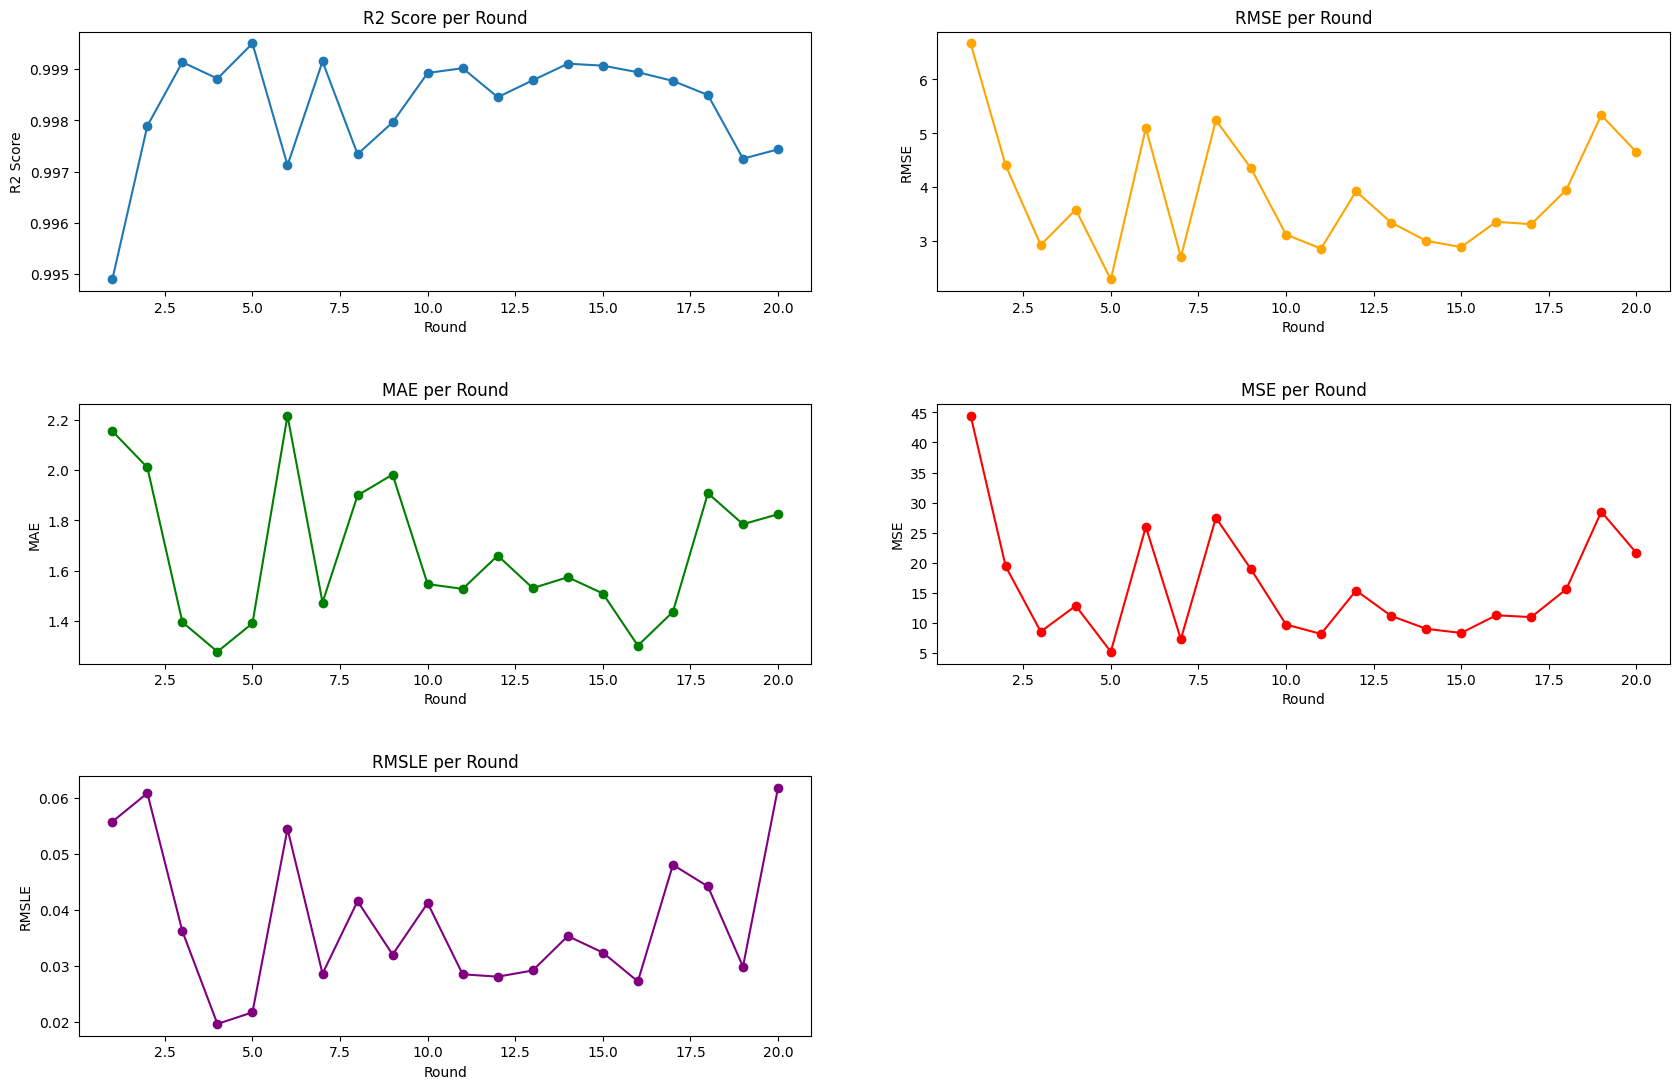

In [99]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_svr.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_decisionTree.png'")
plt.show()

Trong đoạn mã đã trình bày, các chỉ số đánh giá hiệu suất mô hình hồi quy được trực quan hóa qua 20 vòng huấn luyện bao gồm: R², RMSE, MAE, MSE và RMSLE. Việc sử dụng thư viện matplotlib để hiển thị kết quả theo dạng lưới giúp tăng khả năng so sánh và phân tích từng chỉ số riêng biệt theo thời gian huấn luyện.

Biểu đồ R² cho thấy giá trị dao động quanh mức rất cao (> 0.995), phản ánh khả năng mô hình giải thích tốt phương sai dữ liệu đầu ra. Trong khi đó, các chỉ số lỗi như RMSE, MAE, MSE và RMSLE đều thể hiện xu hướng giảm hoặc ổn định ở mức thấp sau một vài vòng đầu, cho thấy mô hình đã dần hội tụ và ít xảy ra hiện tượng quá khớp hoặc dao động lớn.

Đặc biệt, việc loại bỏ subplot dư trong lưới 3x2 giúp bố cục trực quan gọn gàng, đồng thời mã cũng có bước lưu hình ảnh đầu ra, phù hợp với yêu cầu lưu trữ kết quả mô hình trong các báo cáo hoặc luận văn khoa học.

## **Phần 6: Đánh giá hiệu suất tốt nhất qua từng thuật toán**

Dựa trên các biểu đồ so sánh giá trị AQI thực tế và dự đoán từ các mô hình khác nhau, ta có thể đánh giá hiệu suất của từng thuật toán như sau:

---

### **1. Decision Tree**

* **Đặc điểm nhận diện:** Dự đoán (dấu "x" màu xanh lá) khớp khá sát với giá trị thực (dấu "+" màu xanh dương).
* **Hiệu suất:** Tốt — mô hình này tái hiện được nhiều điểm dữ liệu chính xác.
* **Nhận xét:** Có xu hướng học tốt các mẫu huấn luyện nhưng dễ bị overfitting khi gặp nhiễu hoặc mẫu lạ.

---

### **2. KNN (K-Nearest Neighbors)**

* **Đặc điểm:** Dự đoán rải rác và xa giá trị thực, có độ phân tán cao.
* **Hiệu suất:** Kém — nhiều điểm bị lệch đáng kể so với thực tế.
* **Nhận xét:** KNN hoạt động không hiệu quả với dữ liệu AQI này, có thể do phân bố phức tạp hoặc K chưa tối ưu.

---

### **3. Linear Regression**

* **Đặc điểm:** Dự đoán tương đối gần với giá trị thực nhưng vẫn có độ lệch ở các vùng giá trị cao/thấp.
* **Hiệu suất:** Trung bình — phù hợp cho xu hướng tuyến tính nhưng hạn chế với dữ liệu phi tuyến tính.
* **Nhận xét:** Mô hình đơn giản, dễ hiểu nhưng không mô tả được sự phi tuyến trong dữ liệu AQI.

---

### **4. SVR (Support Vector Regression)**

* **Đặc điểm:** Dự đoán gần đúng giá trị thực nhưng vẫn có sai số ở mức vừa phải.
* **Hiệu suất:** Khá — tốt hơn Linear Regression và KNN, nhưng không bằng XGBoost hay Decision Tree.
* **Nhận xét:** SVR có khả năng học tốt trong không gian phức tạp hơn Linear, nhưng cần tinh chỉnh tham số cẩn thận.

---

### **5. XGBoost**

* **Đặc điểm:** Dự đoán gần trùng với giá trị thực tế, các điểm gần như chồng khít.
* **Hiệu suất:** Xuất sắc — sai số nhỏ, độ khớp cao.
* **Nhận xét:** Là mô hình mạnh, phù hợp với dữ liệu phi tuyến và phức tạp như AQI. Có khả năng tổng quát hóa tốt.

---

### **Tổng kết xếp hạng hiệu suất từ tốt đến kém:**

1. **XGBoost** — độ chính xác rất cao, độ khớp gần như hoàn hảo.
2. **Decision Tree** — hiệu quả tốt, nhưng dễ bị overfit nếu không kiểm soát độ sâu.
3. **SVR** — khá tốt, nhưng chưa tối ưu bằng XGBoost.
4. **Linear Regression** — hiệu suất trung bình, không phù hợp với quan hệ phi tuyến.
5. **KNN** — hiệu suất kém nhất trong các mô hình đã thử.

---


## **Phần 7: Kết luận**
Vậy ta kết luận được mô hình XGBoost là tốt nhất so với KNN, SVR, Decision Tree và Linear Regression.

Mô hình XGBoost cho thấy hiệu suất vượt trội trong nhiệm vụ dự đoán chỉ số chất lượng không khí (AQI) từ các đặc trưng thời tiết và ô nhiễm. Với khả năng xử lý quan hệ phi tuyến tính và tận dụng kỹ thuật boosting để kết hợp nhiều cây quyết định yếu, XGBoost đã đạt được độ chính xác cao nhất trong số các mô hình được so sánh. Kết quả biểu đồ cho thấy các giá trị dự đoán gần như trùng khớp với giá trị thực tế, phản ánh khả năng khái quát hóa tốt và độ sai số thấp của mô hình. 

Bên cạnh đó, XGBoost còn có ưu điểm về khả năng kiểm soát overfitting thông qua các siêu tham số như max_depth, learning_rate, và n_estimators.

Những kết quả này khẳng định rằng XGBoost là lựa chọn phù hợp và hiệu quả cho các bài toán dự báo AQI với dữ liệu phức tạp và phi tuyến. 